# 株価予測モデル構築PJT

## データ取得
* yfinanceを使用して、株価データを取得してdfとして格納

In [52]:
import datetime as dt
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib as ta
import yfinance as yf

In [ ]:
# 日本取引所グループ(JPX)が提示している東証上場銘柄リストから一覧を取得
# https://www.jpx.co.jp/markets/statistics-equities/misc/01.html
df_company = pd.read_excel("./data/20231216_data_j.xlsx")
df_company

In [35]:
target_company = input("取得対象の銘柄名を入力：")
x = df_company.query(f"銘柄名 == '{target_company}'")["コード"].to_list()

In [37]:
x

[2413]

In [12]:
# yf.download(対象の株銘柄, 期間, 頻度)
ticker = "2413.T"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31", interval="1d")
data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-18,2200.0,2223.0,2189.5,2213.0,2213.0,2645400
2023-12-19,2200.0,2242.0,2187.0,2237.0,2237.0,2096400
2023-12-20,2263.5,2300.0,2258.0,2291.0,2291.0,2982900
2023-12-21,2245.0,2276.5,2240.0,2255.0,2255.0,2144100
2023-12-22,2280.5,2310.0,2247.0,2251.5,2251.5,2113500


In [35]:
# 上記の関数化
def get_stock_data(ticker, start, end, interval):
    ticker = ticker + ".T"
    df = yf.download(tickers=ticker, start=start, end=end, interval=interval)
    return df

## 可視化

/Users/kohta/workspace/stock_price/venv/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


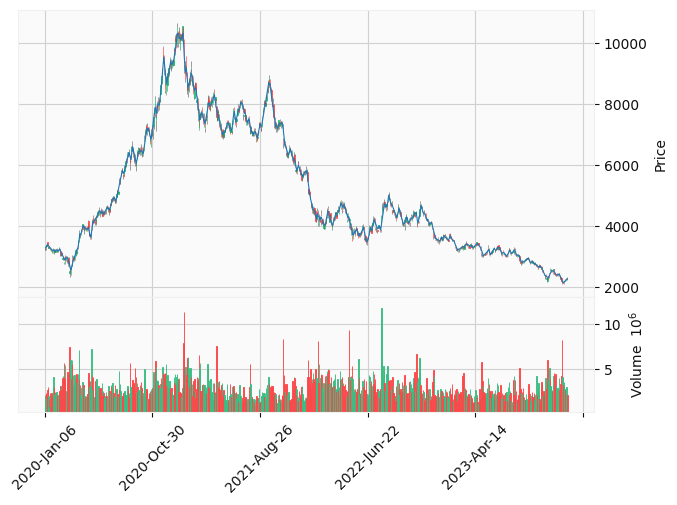

In [4]:
# mplfinanceライブラリを使用した、ローソク足グラフの描画
df = get_stock_data("2413", "2020-01-01", "2023-12-31", "1d")
# df = df.drop("Volume", axis=1)
mpf.plot(df, type="candle", style="yahoo", mav=3, volume=True)  # mav: 移動平均線

In [5]:
# 移動平均値の集計(今回の例では終値(Close)を対象)
price = df["Close"]
span = 30

df["MA_for_30_days"] = price.rolling(window=span, min_periods=1).mean()

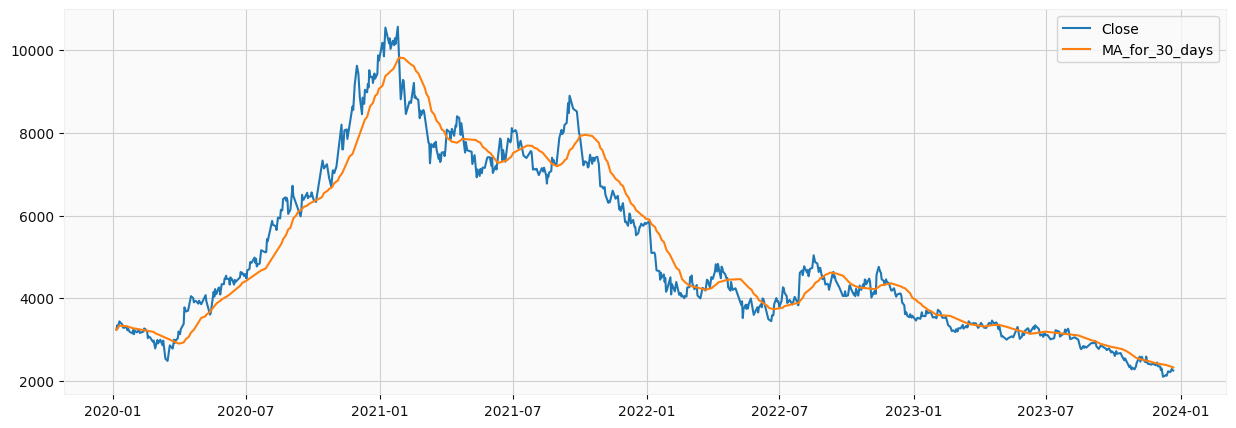

In [6]:
df_ma = df[["Close", "MA_for_30_days"]]
df_ma

plt.figure(figsize=(15, 5))
plt.plot(df_ma.index, df_ma)
plt.legend(df_ma)
plt.show()

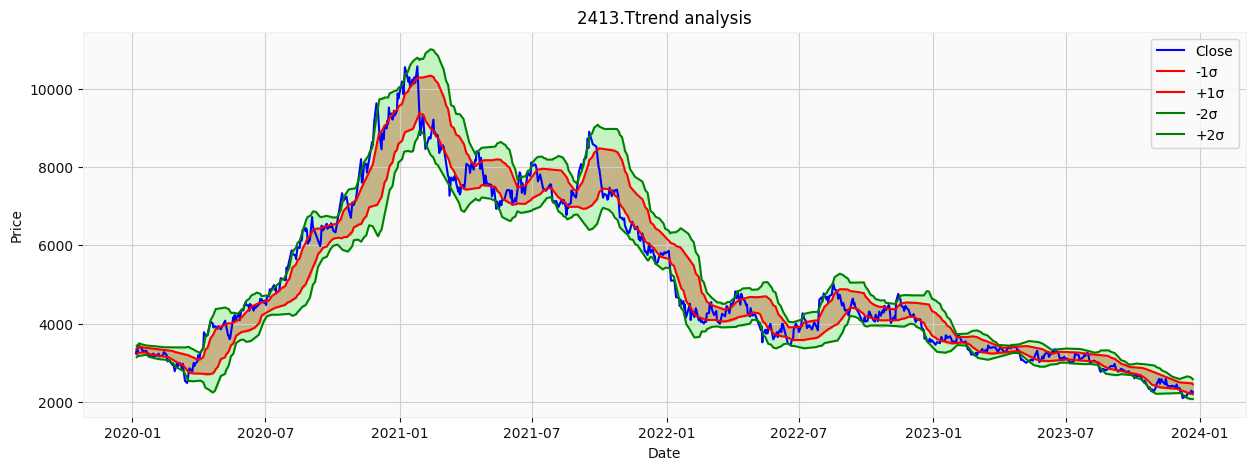

In [7]:
# ボリンジャーバンド
df = get_stock_data("2413", "2020-01-01", "2023-12-31", "1d")
span = 30
df["MA_for_30_days"] = price.rolling(window=span, min_periods=1).mean()
df["std"] = price.rolling(window=span, min_periods=1).std()

df["-1σ"] = df["MA_for_30_days"] - 1 * df["std"]
df["+1σ"] = df["MA_for_30_days"] + 1 * df["std"]
df["-2σ"] = df["MA_for_30_days"] - 2 * df["std"]
df["+2σ"] = df["MA_for_30_days"] + 2 * df["std"]

plt.figure(figsize=(15, 5))
plt.title(ticker + "trend analysis")
plt.plot(df["Close"], color="blue")
plt.plot(df["-1σ"], color="red")
plt.plot(df["+1σ"], color="red")
plt.plot(df["-2σ"], color="green")
plt.plot(df["+2σ"], color="green")
plt.fill_between(df.index, df["-1σ"], df["+1σ"], color="red", alpha=0.5)
plt.fill_between(df.index, df["-2σ"], df["+2σ"], color="lightgreen", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Close", "-1σ", "+1σ", "-2σ", "+2σ"], loc="upper right")
plt.show()

## TA-Libを用いたテクニカル指標の作成
* TA-Libライブラリ
  * 金融データを分析する機能を多く備えたライブラリ
* よく使う指標
  * 移動平均
  * ボリンジャーバンド(移動平均からの±標準偏差)
  * 乖離率
  * MACD(Moving Average Convergence Divergence：移動平均収縮拡散手法)
    * 売買シグナルの転換見極め
  * RSI(Relative Strength Index：相対力指数)

### 移動平均線

/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/2372285946.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


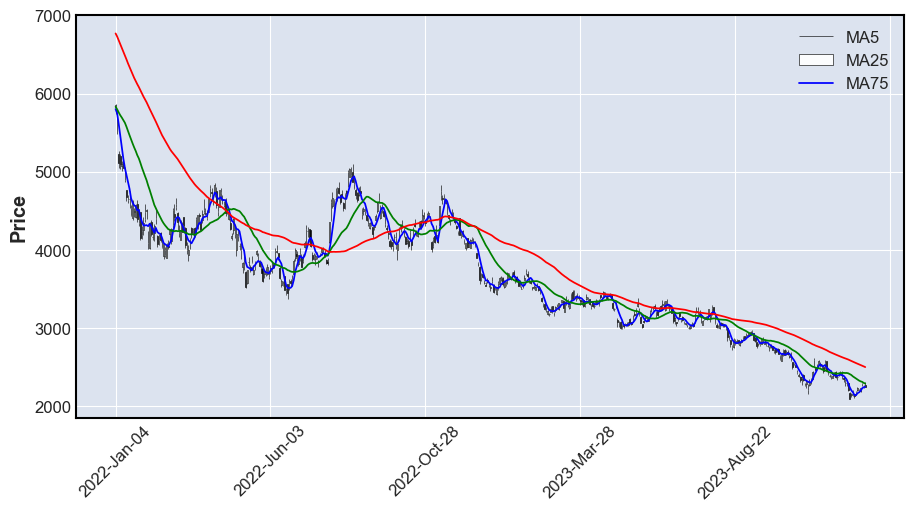

In [14]:
df = get_stock_data("2413", "2020-01-01", "2023-12-31", "1d")

# 移動平均値の算出
df["ma5"] = ta.SMA(df["Close"], 5)
df["ma25"] = ta.SMA(df["Close"], 25)
df["ma75"] = ta.SMA(df["Close"], 75)

cdf = df[dt.datetime(2022, 1, 1) : dt.datetime(2023, 12, 31)]
apd = [
    mpf.make_addplot(cdf["ma5"], color="blue"),
    mpf.make_addplot(cdf["ma25"], color="green"),
    mpf.make_addplot(cdf["ma75"], color="red"),
]

fig, axes = mpf.plot(cdf, type="candle", figratio=(2, 1), addplot=apd, returnfig=True)
axes[0].legend(["MA5", "MA25", "MA75"])
fig.show()

### ボリンジャーバンド

/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/3404843225.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


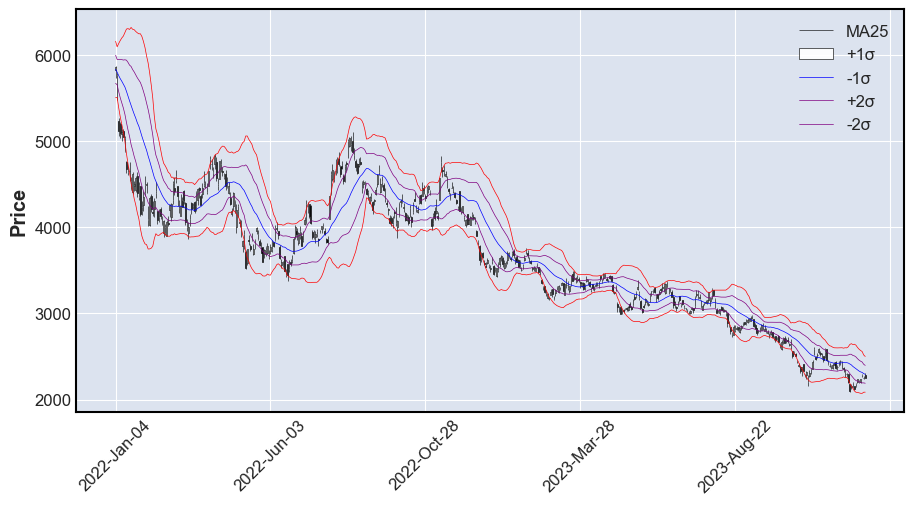

In [19]:
df = get_stock_data("2413", "2020-01-01", "2023-12-31", "1d")
close = df["Close"]

# 25日移動平均線
df["ma25"] = ta.SMA(df["Close"], 25)

# ボリンジャーバンド ±1σ, ±2σ
df["upper1"], _, df["lower1"] = ta.BBANDS(
    close, timeperiod=25, nbdevup=1, nbdevdn=1, matype=ta.MA_Type.SMA
)
df["upper2"], _, df["lower2"] = ta.BBANDS(
    close, timeperiod=25, nbdevup=2, nbdevdn=2, matype=ta.MA_Type.SMA
)

cdf = df[dt.datetime(2022, 1, 1) : dt.datetime(2023, 12, 31)]
apd = [
    mpf.make_addplot(cdf["ma25"], color="blue", width=0.5),
    mpf.make_addplot(cdf["upper1"], color="purple", width=0.5),
    mpf.make_addplot(cdf["lower1"], color="purple", width=0.5),
    mpf.make_addplot(cdf["upper2"], color="red", width=0.5),
    mpf.make_addplot(cdf["lower2"], color="red", width=0.5),
]

# ラベル付けしてチャートを表示
fig, axes = mpf.plot(cdf, type="candle", figratio=(2, 1), addplot=apd, returnfig=True)
axes[0].legend(["MA25", "+1σ", "-1σ", "+2σ", "-2σ"])
fig.show()

### 乖離率
乖離率 = (終値 - 平均値) / 平均値 * 100

[*********************100%%**********************]  1 of 1 completed


/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/2893486538.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/2893486538.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


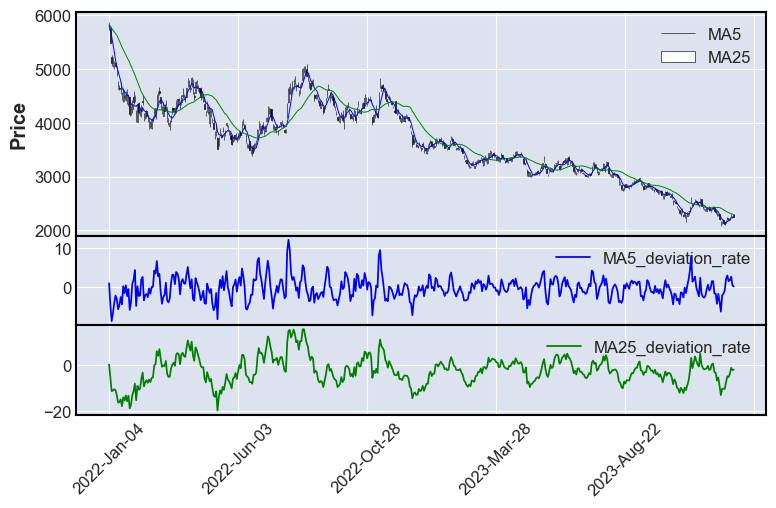

In [29]:
df = get_stock_data("2413", "2020-01-01", "2023-12-31", "1d")
close = df["Close"]

# 移動平均
df["ma5"] = ta.SMA(close, 5)
df["ma25"] = ta.SMA(close, 25)

# 乖離率
df["ma5_deviation_rate"] = (close - df["ma5"]) / df["ma5"] * 100
df["ma25_deviation_rate"] = (close - df["ma25"]) / df["ma25"] * 100

cdf = df[dt.datetime(2022, 1, 1) : dt.datetime(2023, 12, 31)]

# panelプロパティで別のパネル(グラフ)として表示
apd = [
    mpf.make_addplot(cdf["ma5"], color="blue", panel=0, width=0.7),
    mpf.make_addplot(cdf["ma25"], color="green", panel=0, width=0.7),
    mpf.make_addplot(cdf["ma5_deviation_rate"], color="blue", panel=1),
    mpf.make_addplot(cdf["ma25_deviation_rate"], color="green", panel=2),
]

fig, axes = mpf.plot(cdf, type="candle", figratio=(5, 3), addplot=apd, returnfig=True)
axes[0].legend(["MA5", "MA25"])
axes[2].legend(["MA5_deviation_rate"])
axes[4].legend(["MA25_deviation_rate"])
fig.tight_layout()
fig.show()

### ゴールデンクロスとデッドクロス

* ゴールデンクロス：短期線 > 長期線
  * 短期線の角度がキツめについていることも大事
* デッドクロス：短期線 < 長期線

[*********************100%%**********************]  1 of 1 completed

/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/1509102634.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


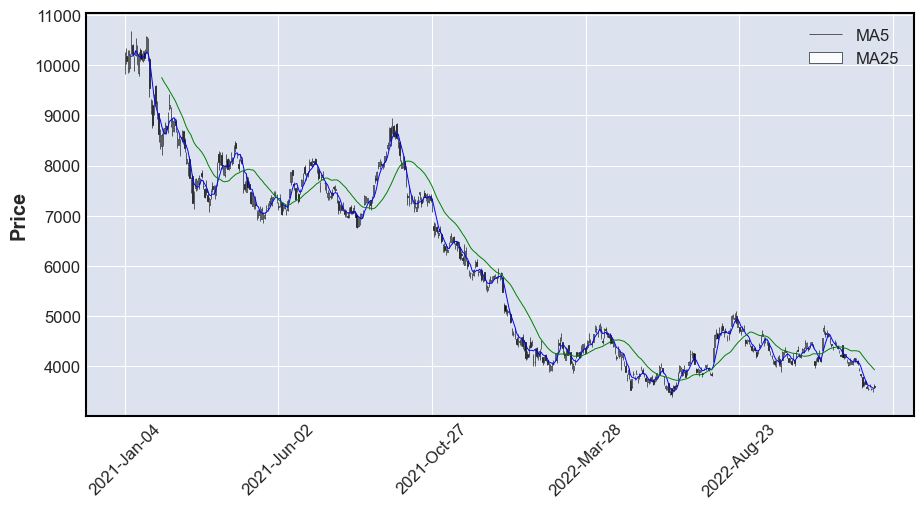

In [37]:
df = get_stock_data("2413", "2021-01-01", "2022-12-31", "1d")
close = df["Close"]
df["ma5"] = ta.SMA(close, timeperiod=5)
df["ma25"] = ta.SMA(close, timeperiod=25)

apd = [
    mpf.make_addplot(df["ma5"], color="blue", panel=0, width=0.7),
    mpf.make_addplot(df["ma25"], color="green", panel=0, width=0.7),
]

fig, axes = mpf.plot(df, type="candle", figratio=(2, 1), addplot=apd, returnfig=True)
axes[0].legend(["MA5", "MA25"])
fig.show()

#### ゴールデンクロスとデッドクロスをデータで持つ
1. 5日移動平均と25日移動平均の値を比較して、結果を正負で得る
2. 比較した結果の、"正負が入れ替わった日"がゴールデンクロスかデッドクロスの発生日
3. ゴールデンクロスの発生日に5日移動平均の値(高い方の値)、デッドクロスの発生日に25日移動平均(安い方の値)を保存する

In [57]:
df = get_stock_data("2413", "2021-01-01", "2022-12-31", "1d")
close = df["Close"]
df["ma5"] = ta.SMA(close, timeperiod=5)
df["ma25"] = ta.SMA(close, timeperiod=25)

cross = df["ma5"] > df["ma25"]  # 5日移動平均と25日移動平均の比較
df["cross"] = cross

cross_shift = cross.shift(1)  # 1日ずらしの値

[*********************100%%**********************]  1 of 1 completed


In [58]:
# ゴールデンクロスの発生日
temp_gc = (cross != cross_shift) & (cross == True)
# デッドクロスの発生日
temp_dc = (cross != cross_shift) & (cross == False)
temp_gc

Date
2021-01-04    False
2021-01-05    False
2021-01-06    False
2021-01-07    False
2021-01-08    False
              ...  
2022-12-26    False
2022-12-27    False
2022-12-28    False
2022-12-29    False
2022-12-30    False
Length: 489, dtype: bool

In [80]:
# ゴールデンクロス発生日であればMA5の値、それ以外はNan
gc = [m if g == True else np.nan for g, m in zip(temp_gc, df["ma5"])]
# デッドクロスの発生日であればMA25の値、それ以外はNan
dc = [m if d == True else np.nan for d, m in zip(temp_dc, df["ma25"])]

# データフレームでカラムとして保存
df["gc"], df["dc"] = gc, dc
df

,Open,High,Low,Close,Adj Close,Volume,ma5,ma25,macd,macd_signal,hist,gc,dc
Date,,,,,,,,,,,,,
2021-01-04,9877.0,10260.0,9822.0,10180.0,10069.867188,4449900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,10180.0,10345.0,10035.0,10085.0,9975.894531,3204900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,10190.0,10305.0,9843.0,9851.0,9744.425781,3373500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,9943.0,10300.0,9875.0,10230.0,10119.325195,4073000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,10300.0,10675.0,10230.0,10545.0,10430.916992,4422100,10178.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3551.0,3593.0,3535.0,3543.0,3522.905518,1568300,3610.4,4062.20,-187.133786,-135.722341,-51.411445,NaN,NaN
2022-12-27,3588.0,3638.0,3577.0,3615.0,3594.497070,1958100,3610.6,4030.16,-188.275564,-146.232986,-42.042578,NaN,NaN
2022-12-28,3556.0,3575.0,3532.0,3551.0,3530.860107,2012900,3586.8,3999.20,-192.129942,-155.412377,-36.717565,NaN,NaN


/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/1013729750.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


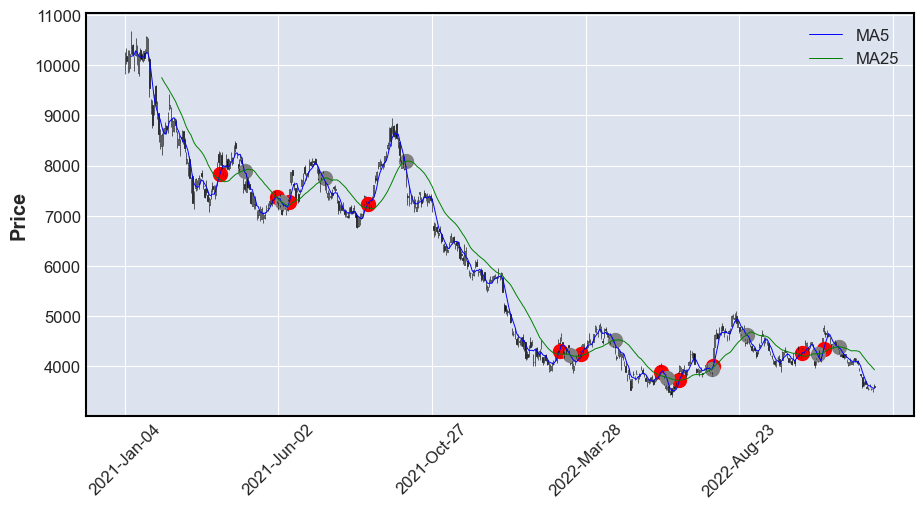

In [81]:
# チャートにゴールデンクロスとデッドクロスを表示
# 凡例の付け方が変わったようで、各labelプロパティをつけるとちゃんと表示される
apd = [
    mpf.make_addplot(df["ma5"], color="blue", panel=0, width=0.7, label="MA5"),
    mpf.make_addplot(df["ma25"], color="green", panel=0, width=0.7, label="MA25"),
    mpf.make_addplot(df["gc"], type="scatter", markersize=100, marker="o", color="red"),
    mpf.make_addplot(
        df["dc"], type="scatter", markersize=100, marker="o", color="gray"
    ),
]

fig, axes = mpf.plot(df, type="candle", figratio=(2, 1), addplot=apd, returnfig=True)
# axes[0].legend(["MA5", "MA25"])
fig.show()

### MACD
* 移動平均収縮拡散手法(Moving Average Convergence Divergence)
* 移動平均で判断できる売買シグナルの検出精度を上げたもの
* 単純移動平均ではなく、直近の価格になるほど比重をおいて計算する「平滑移動平均(EMA：Exponential Moving Average)」を使用する
* MACDは次の3つの要素で構成される
  * MACD(折れ線)：短期/長期の平滑移動平均の差
  * シグナル(折れ線)：MACDの平滑移動平均
  * ヒストグラム(棒)：MACDとシグナルの差

[*********************100%%**********************]  1 of 1 completed

/var/folders/q5/s5mcbmt95hd29sp3b9xmr2580000gn/T/ipykernel_56190/1923401256.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


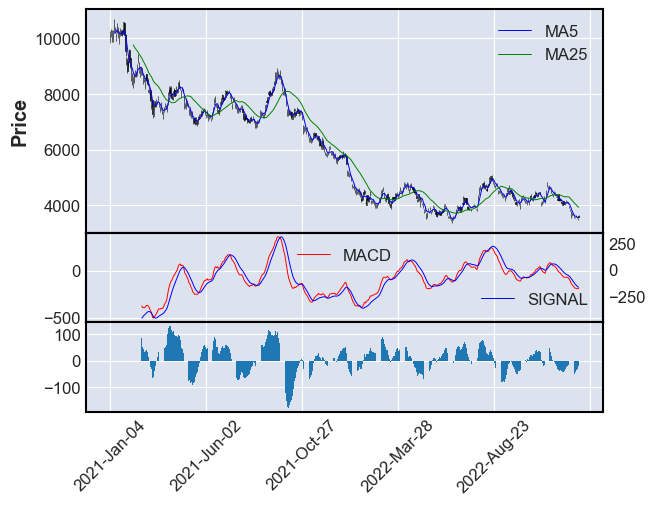

In [78]:
df = get_stock_data("2413", "2021-01-01", "2022-12-31", "1d")
close = df["Close"]

# 移動平均
df["ma5"] = ta.SMA(close, timeperiod=5)
df["ma25"] = ta.SMA(close, timeperiod=25)

# MACD
macd, macdsignal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df["macd"] = macd
df["macd_signal"] = macdsignal
df["hist"] = hist

apd = [
    mpf.make_addplot(df["ma5"], color="blue", panel=0, width=0.7, label="MA5"),
    mpf.make_addplot(df["ma25"], color="green", panel=0, width=0.7, label="MA25"),
    mpf.make_addplot(df["macd"], color="red", panel=1, width=0.7, label="MACD"),
    mpf.make_addplot(
        df["macd_signal"], color="blue", panel=1, width=0.7, label="SIGNAL"
    ),
    mpf.make_addplot(df["hist"], panel=2, type="bar"),
]

fig, axes = mpf.plot(df, type="candle", figratio=(5, 4), addplot=apd, returnfig=True)
fig.show()